✅ 라이브러리 임포트 완료
❌ Firestore 연결 실패: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.
❗️ 'YOUR_SERVICE_ACCOUNT_KEY_PATH' 변수를 올바른 경로로 수정했는지 확인하세요.
Firestore에서 'raw_data' (훈련 데이터)를 로드합니다...


C:\src\flutter_app\functions\venv\Lib\site-packages\google\cloud\firestore_v1\base_collection.py:304: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


✅ 총 2220건의 훈련 데이터 로드 완료.
label
Deep       470
REM        370
Apnea      340
Snoring    300
Awake      260
Light      250
Tossing    230
Name: count, dtype: int64
데이터 시각화를 생성합니다... (시간이 몇 초 걸릴 수 있습니다)


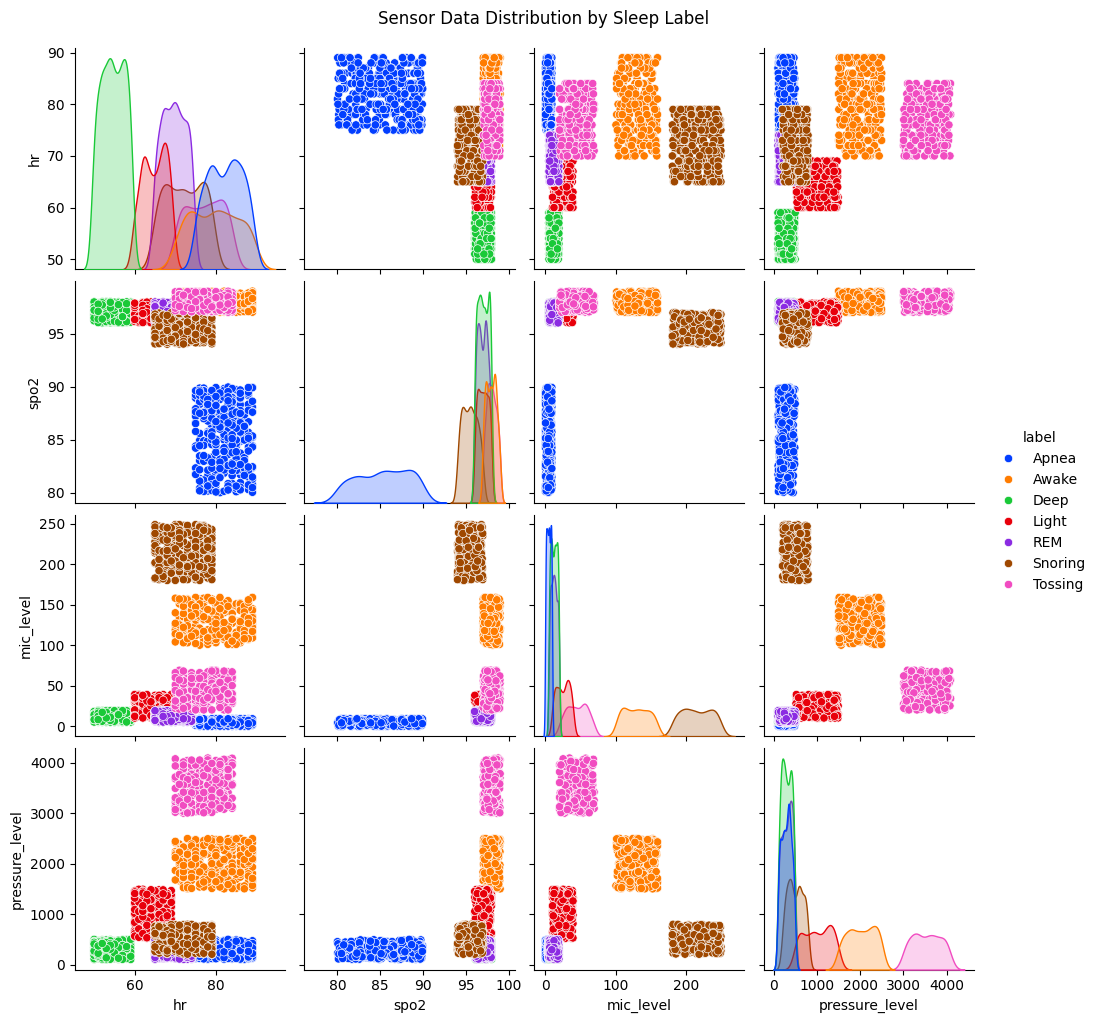

✅ 시각화 완료. 그래프를 확인하여 7개 라벨이 잘 구분되는지 확인하세요.

--- 🧠 '진짜 뇌' 성능 평가 (Accuracy) ---
✅ 모델 정확도: 100.00%

--- 상세 분류 리포트 ---
              precision    recall  f1-score   support

       Apnea       1.00      1.00      1.00        68
       Awake       1.00      1.00      1.00        52
        Deep       1.00      1.00      1.00        94
       Light       1.00      1.00      1.00        50
         REM       1.00      1.00      1.00        74
     Snoring       1.00      1.00      1.00        60
     Tossing       1.00      1.00      1.00        46

    accuracy                           1.00       444
   macro avg       1.00      1.00      1.00       444
weighted avg       1.00      1.00      1.00       444



--- 🚀 3단계에 복사할 '진짜 뇌' Python 코드 ---
def predict_stage_by_tree(hr: float, spo2: float, mic_level: float, pressure_level: float) -> str:
    # Auto-generated from DecisionTree (Accuracy: 100.00%)
    # Trained on 2220 data points.
    if hr <= 59.5:
        return "Deep"
    else: # if hr

In [ ]:
# === 1. 라이브러리 임포트 ===
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, _tree, export_text
from sklearn.metrics import classification_report, confusion_matrix

print("✅ 라이브러리 임포트 완료")

# === 2. Firestore 연결 ===
# ❗️ 중요: "path/to/..."를 당신의 서비스 계정 키 파일 경로로 수정하세요!
YOUR_SERVICE_ACCOUNT_KEY_PATH = r"C:\Users\USER\Downloads\capstone-sleep-firebase-adminsdk-fbsvc-faeba951af.json"

try:
    cred = credentials.Certificate(YOUR_SERVICE_ACCOUNT_KEY_PATH)
    firebase_admin.initialize_app(cred)
    db = firestore.client()
    print("✅ Firestore 연결 성공!")
except Exception as e:
    print(f"❌ Firestore 연결 실패: {e}")
    print("❗️ 'YOUR_SERVICE_ACCOUNT_KEY_PATH' 변수를 올바른 경로로 수정했는지 확인하세요.")

# === 3. 데이터 로드 (Firestore -> Pandas) ===
print("Firestore에서 'raw_data' (훈련 데이터)를 로드합니다...")
# 'label' 필드가 있는 훈련 데이터만 모두 가져옵니다.
docs = db.collection(u'raw_data').where(u'label', u'!=', None).stream()

records = []
for doc in docs:
    records.append(doc.to_dict())

df = pd.DataFrame(records)
print(f"✅ 총 {len(df)}건의 훈련 데이터 로드 완료.")
print(df['label'].value_counts()) # 라벨별 데이터 개수 확인

# === 4. 데이터 시각화 (EDA) ★★★ ===
# (JupyterLab을 쓰는 이유!)
# 4대 핵심 센서와 'label' 간의 관계를 시각화합니다.
print("데이터 시각화를 생성합니다... (시간이 몇 초 걸릴 수 있습니다)")
features_to_plot = ['hr', 'spo2', 'mic_level', 'pressure_level', 'label']
sns.pairplot(df[features_to_plot], hue='label', palette='bright')
plt.suptitle("Sensor Data Distribution by Sleep Label", y=1.02)
plt.show()
print("✅ 시각화 완료. 그래프를 확인하여 7개 라벨이 잘 구분되는지 확인하세요.")
# 
# 

# === 5. "진짜 뇌" 학습 (Decision Tree) ===
# 4대 핵심 센서를 '특징 (X)'으로, 'label'을 '정답 (y)'으로 설정합니다.
feature_names = ['hr', 'spo2', 'mic_level', 'pressure_level']
target_name = 'label'

# 결측치(NaN)가 있는 행을 제거하여 데이터를 정리합니다.
df_clean = df.dropna(subset=feature_names + [target_name])

X = df_clean[feature_names]
y = df_clean[target_name]

# 데이터를 '훈련용'과 '테스트용'으로 8:2 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 의사결정트리 "뇌" 모델 생성 및 학습
clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# "뇌" 성능 평가
print("\n--- 🧠 '진짜 뇌' 성능 평가 (Accuracy) ---")
accuracy = clf.score(X_test, y_test)
print(f"✅ 모델 정확도: {accuracy * 100:.2f}%")

print("\n--- 상세 분류 리포트 ---")
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# === 6. "뇌" -> Python 함수 코드로 자동 변환 (★핵심★) ===
# (이전 대화에서 사용했던 그 스크립트)

def emit_tree_function(clf, feature_names, class_names, fname='predict_stage_by_tree', decimals=4):
    tree = clf.tree_
    feat = tree.feature
    thr = tree.threshold
    val = tree.value
    
    assert set(feature_names) == {'hr', 'spo2', 'mic_level', 'pressure_level'}, \
        "❗️ feature_names가 ['hr', 'spo2', 'mic_level', 'pressure_level']와 일치하지 않습니다!"

    lines = []
    lines.append(f"def {fname}(hr: float, spo2: float, mic_level: float, pressure_level: float) -> str:")
    lines.append(f"    # Auto-generated from DecisionTree (Accuracy: {accuracy * 100:.2f}%)")
    lines.append(f"    # Trained on {len(df_clean)} data points.")
    
    def indent(n): return "    " * n

    def recurse(node, depth):
        if feat[node] != _tree.TREE_UNDEFINED:
            name = feature_names[feat[node]]
            threshold = round(float(thr[node]), decimals)
            lines.append(f"{indent(depth)}if {name} <= {threshold}:")
            recurse(tree.children_left[node], depth+1)
            lines.append(f"{indent(depth)}else: # if {name} > {threshold}")
            recurse(tree.children_right[node], depth+1)
        else:
            counts = val[node][0]
            cls_idx = int(np.argmax(counts))
            cls = class_names[cls_idx]
            lines.append(f"{indent(depth)}return \"{cls}\"")

    recurse(0, 1)
    return "\n".join(lines)

print("\n\n--- 🚀 3단계에 복사할 '진짜 뇌' Python 코드 ---")
# 클래스 이름(라벨)의 순서가 모델과 정확히 일치하도록 clf.classes_ 사용
generated_function_code = emit_tree_function(
    clf, 
    feature_names, 
    list(clf.classes_)
)
print(generated_function_code)
# --- 코드 끝 ---
